# IR Search Engine

In [1]:
import pandas as pd

import search
import visualize

## Geting data

### Scraping and preprocesing

To download articles, start with the file "scrape.py".
It works as follows:
-   After giving the initial page, we get the desired number of links. Searching for these links is based on the BFS method, thanks to which our articles   are related to each other, which will allow us to better analyze the operation of the rest of the program. It is also worth mentioning the prevention of duplicate links (wikipedia very often suggests to look from page A to page B and from page B to page A)
     -    if we do not specify the start page, we will get the desired number of links selected randomly based on a special Wikipedia link
-    Next step is fetching all links
-    Then text from each article is preprocesed
     -    lematization
     -    using only small letters
     -    deleting stopwords
-    Last step is exporting articles to file. There is two options- csv or parquet    

In [2]:
docs_df = pd.read_parquet("related_large_set_den.pq")
texts = docs_df.text.tolist()
texts = [text.replace(";", " ") for text in texts]

### Analyse data after scraping and preprocesing

We can analyze our data, i.e. Wikipedia pages after preprocessing. This will allow us to evaluate later how searches for similar articles work.

In the case described below, the base article, i.e. the one from which we started BFS, is https://en.wikipedia.org/wiki/Denmark.

In [3]:
visualize_df = docs_df.copy(deep = True)
visualize_df.text = texts

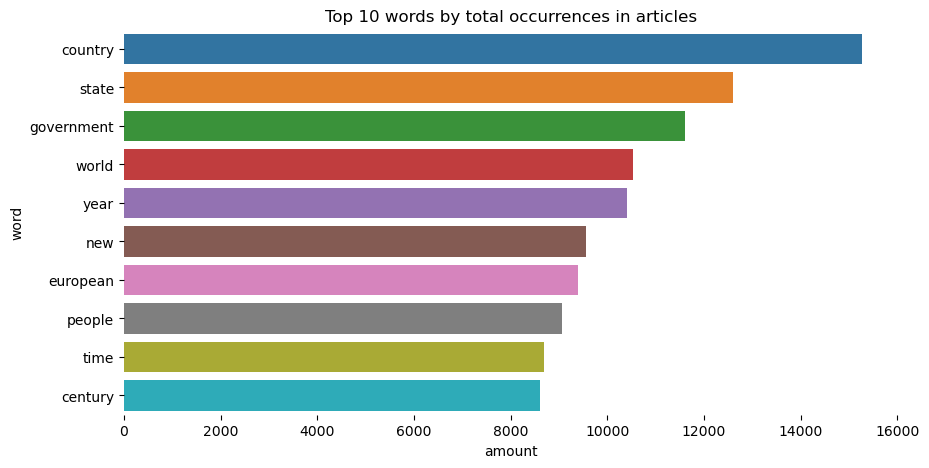

In [4]:
visualize.visualize_most_frequent(visualize_df, 10)

Plot above shows ten words with the most occurrences in the text. We can see the words that follow directly from the initial article we chose- government and country. Words such as world or people are also not surprising. 
A large number of words such as century, year or time may suggest that the BFS method found a large number of articles related to history.

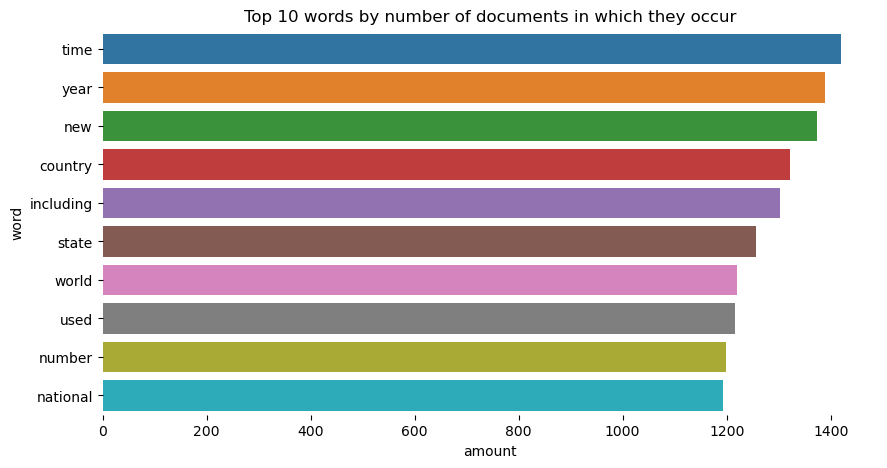

In [5]:
visualize.visualize_most_frequent(visualize_df, 10, method="count")

This plot is presenting words which occur in most articles. You can notice many words that are very universal on the basis of which it is difficult to predict what the article is about - new, used, number, including. However, we have a large group of words related to time, which may suggest a connection with history (time, year) and ?państowość/polityka? (country, world, national).  

## Similarities

### Creating tfidf


The first step before starting to look for similarities between articles is to prepare the tool necessary for this task. 

Simple Search Engine, after receiving texts, vectorizes them at the same time creating tfidf. It is worth mentioning that we can determine the threshold according to which words with the smallest tfidf will not be taken into account.

In [7]:
engine = search.SimpleSearchEngine()
engine.compile_index(texts, docs_df.url.tolist())

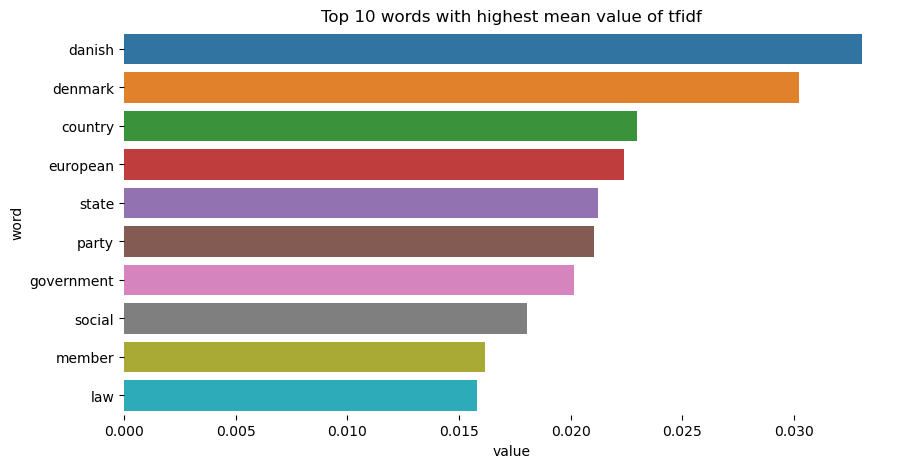

In [8]:
visualize.visualize_tfidf(engine.index, 10)

In plot above we can see ten words with the highest mean value in tfidf. Unlike words before (which were often very general), now we have words that are much more specific and related to a given topic - danish, denmark, european, government, social, law. It is worth noting that, for example, the words "year" and "used" are not in the above-mentioned words, although they were very numerous and appeared in many articles. At the same time, the words "danish" and "denmark" appear to us for the first time. This is extremely important and fully reflects the idea of ​​how tfidf works.

### Geting most similiar

When our engine is fully ready, we can provide it with urls to which it should find similar articles.

Similarity counting is based on cosine similarity.

Let's start with sth easy. Scania Regional Council is the regional council of Scania County in Sweden.

https://en.wikipedia.org/wiki/Scania                 0.489608
https://en.wikipedia.org/wiki/Counties_of_Denmark    0.362108
https://en.wikipedia.org/wiki/Regions_of_Denmark     0.352237
Name: _SCORE_TOTAL, dtype: float64


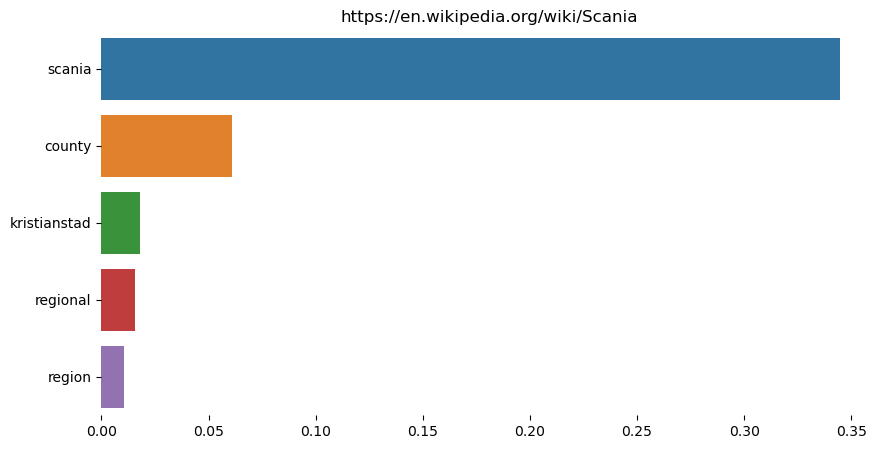

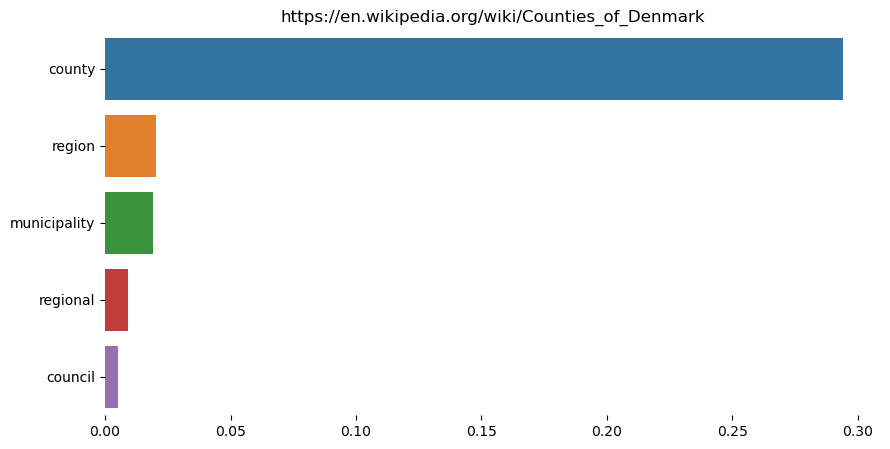

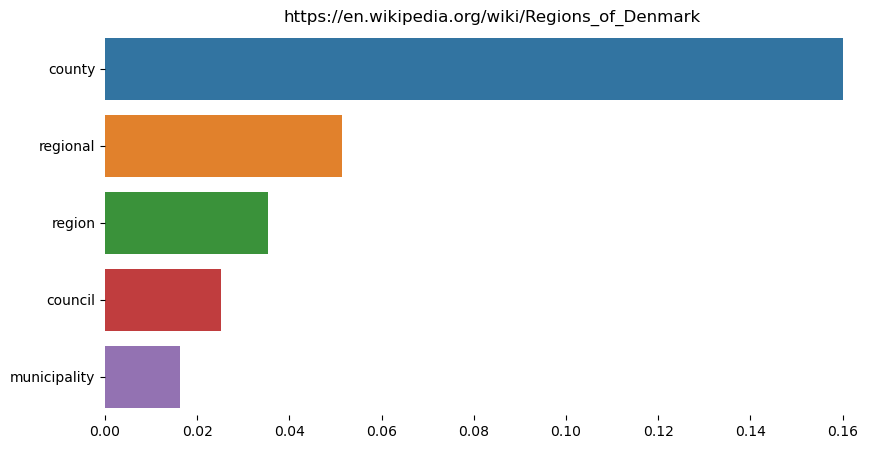

In [9]:
url = "https://en.wikipedia.org/wiki/Scania_Regional_Council"
query = search.wiki_page_from_url_to_content_text(url) 

scores_df = engine.get_scores_dataframe_from_query(query, top_n=3)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 5)

The first article is about Scania which is the main city of Scania Regional Council, so the result is very good - we can see that the most important words was "scania" and it is not a suprise. Second and third articles was related to the administrative division of Denmark. It's because our dataset stared in Denmark we don't have probably much pages about Sweden. The most important words are words referring to the administrative division of the country - county, regional, region, council.

Now it's time for sth more difficult. Two urls with two capitals - Berlin and Moscow

https://en.wikipedia.org/wiki/Russia                 0.202926
https://en.wikipedia.org/wiki/Germany                0.193364
https://en.wikipedia.org/wiki/S-train                0.187628
https://en.wikipedia.org/wiki/Cold_War               0.159534
https://en.wikipedia.org/wiki/Russian_Empire         0.153937
https://en.wikipedia.org/wiki/Europe                 0.150461
https://en.wikipedia.org/wiki/Copenhagen,_Denmark    0.142852
https://en.wikipedia.org/wiki/Copenhagen             0.142852
https://en.wikipedia.org/wiki/Capital_city           0.135455
https://en.wikipedia.org/wiki/Northern_Germany       0.124440
Name: _SCORE_TOTAL, dtype: float64


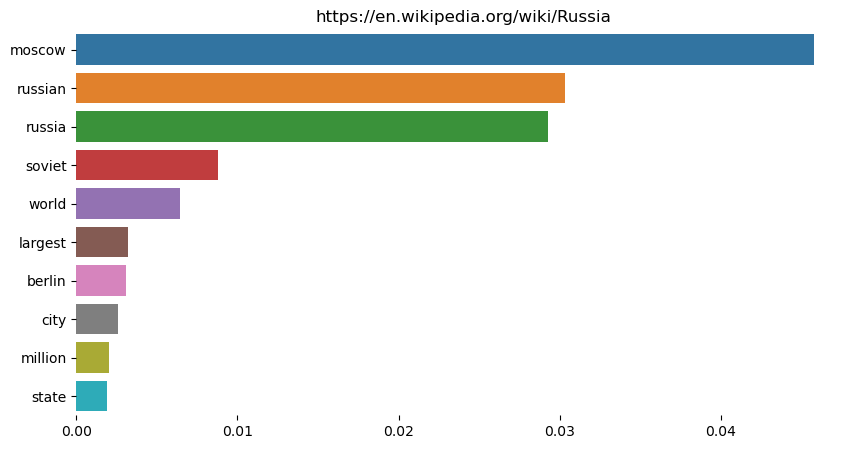

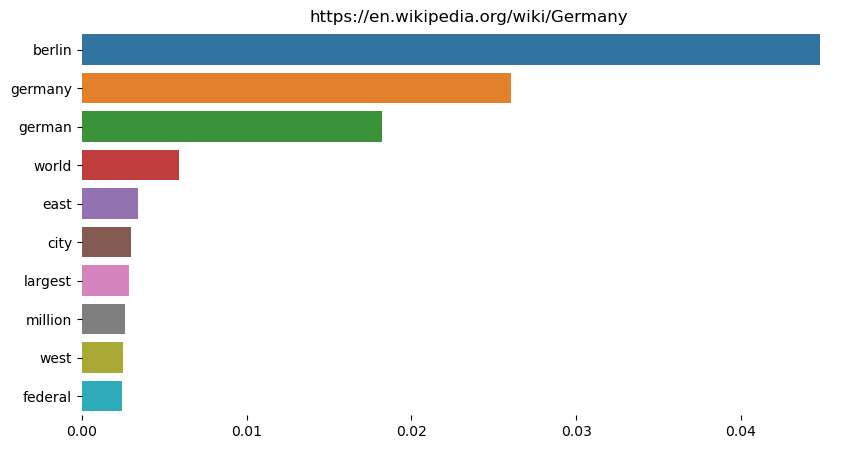

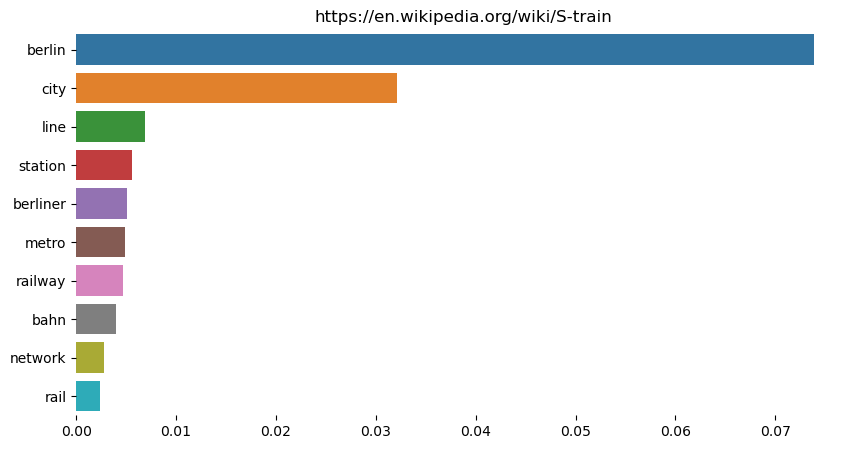

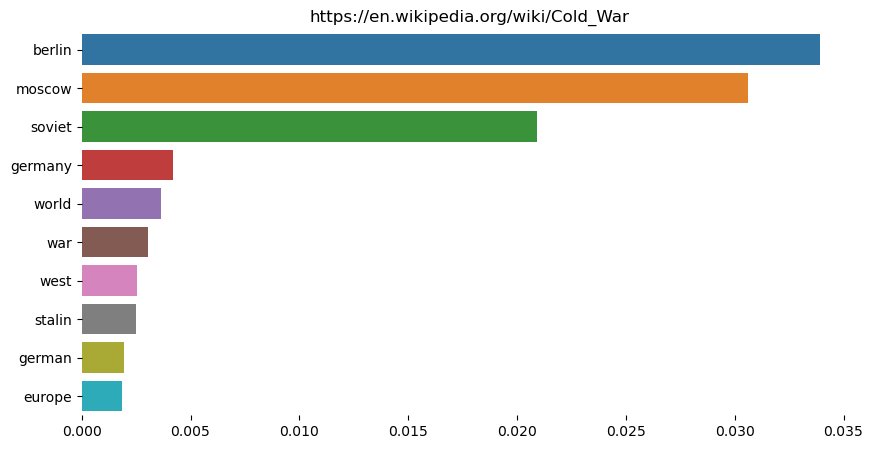

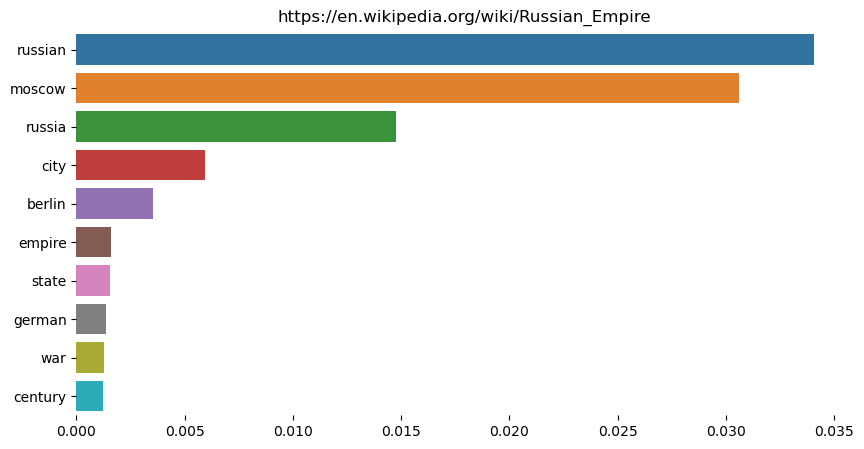

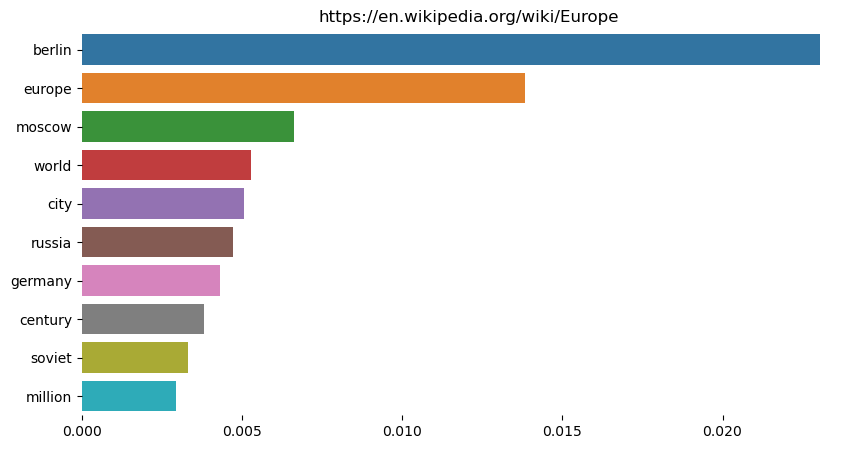

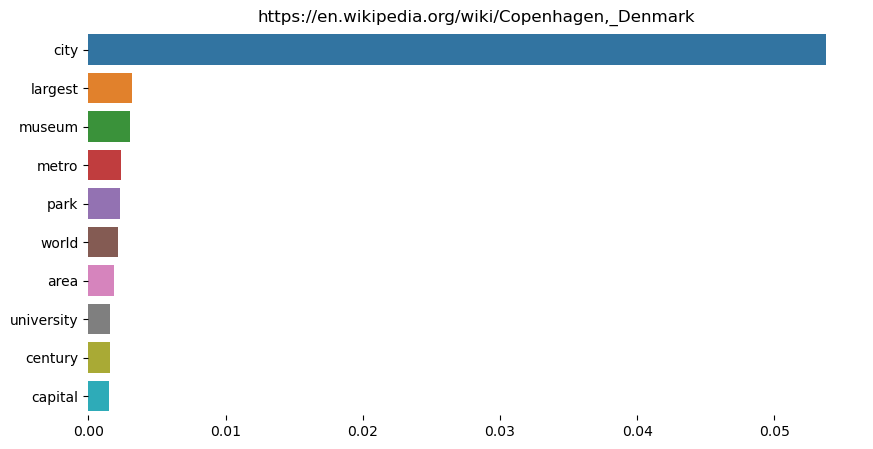

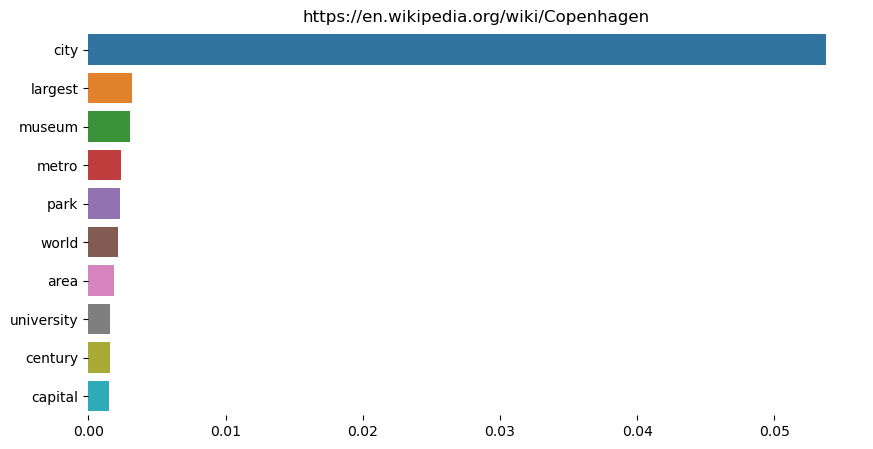

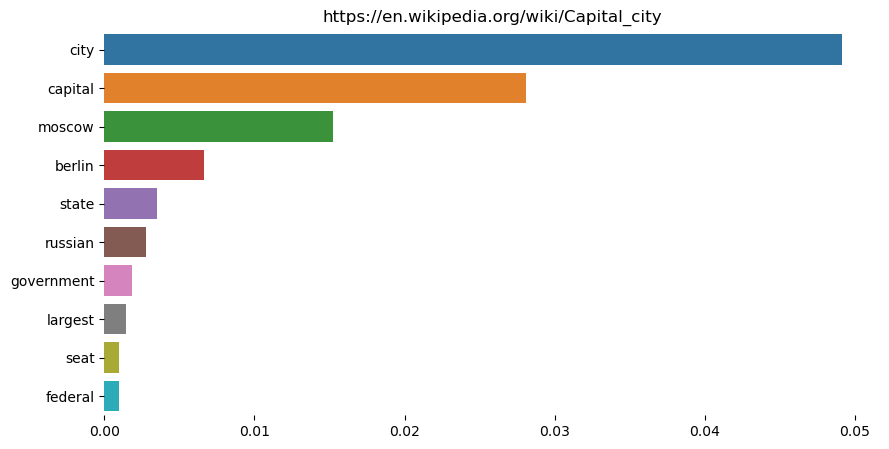

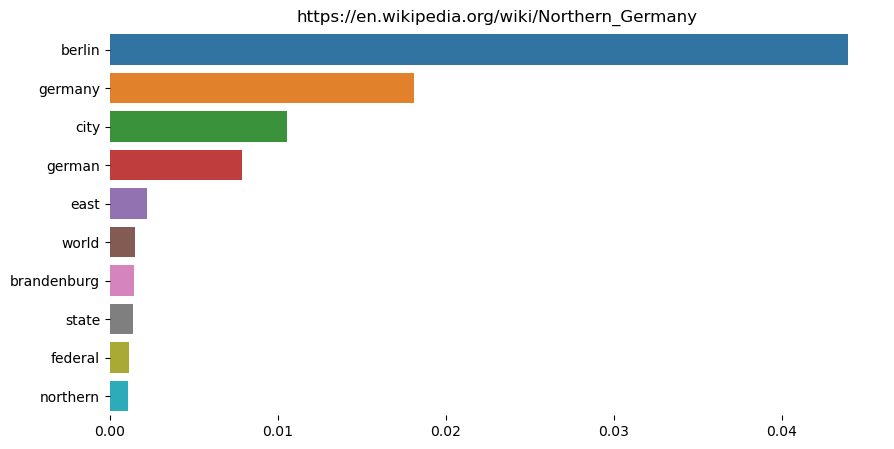

In [10]:
urls = ["https://en.wikipedia.org/wiki/Berlin", "https://en.wikipedia.org/wiki/Moscow"]
queries = [search.wiki_page_from_url_to_content_text(url) for url in urls]

scores_df = engine.get_scores_dataframe_from_queries(queries, top_n=10)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 10)

First two articles are Germany and Russia with very similar similarities it seems to be perfect and don't need an explanation. We can see that the most important words are just berlin and moscow but also russian, russia and soviet in case of Moscow. In case of Berlin - germany and german. 
A big surprise for us may be the third article - S train. However, when we check what this train is, it turns out that it is simply the Berlin subway. Therefore, the most important words are "berlin" and "city" and "line" and "station". The following articles can be divided into those that go towards the history of Germany and Russia, where the most important words are related to these countries (german, russia, etc.). The second direction is the capital. We have an article about capital cities and Copenhagen, the capital of Denmark. In these cases, the most important word is the city and words related to the infrastructure of cities, such as museum.

At the end sth difficult - pages that should't have words in our dataset, kangaroo and penguin

https://en.wikipedia.org/wiki/Australia                   0.081306
https://en.wikipedia.org/wiki/Pinniped                    0.053716
https://en.wikipedia.org/wiki/List_of_birds_of_Denmark    0.049617
https://en.wikipedia.org/wiki/New_Zealand                 0.048699
https://en.wikipedia.org/wiki/Orca                        0.044720
https://en.wikipedia.org/wiki/Global_warming              0.042001
Name: _SCORE_TOTAL, dtype: float64


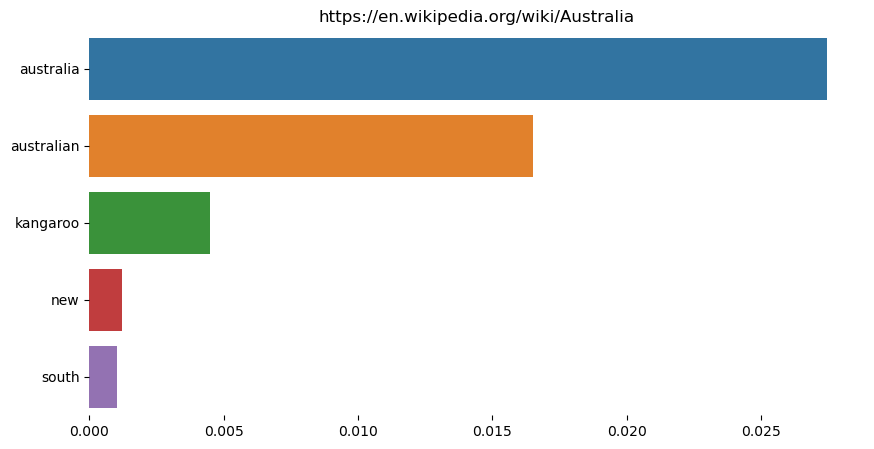

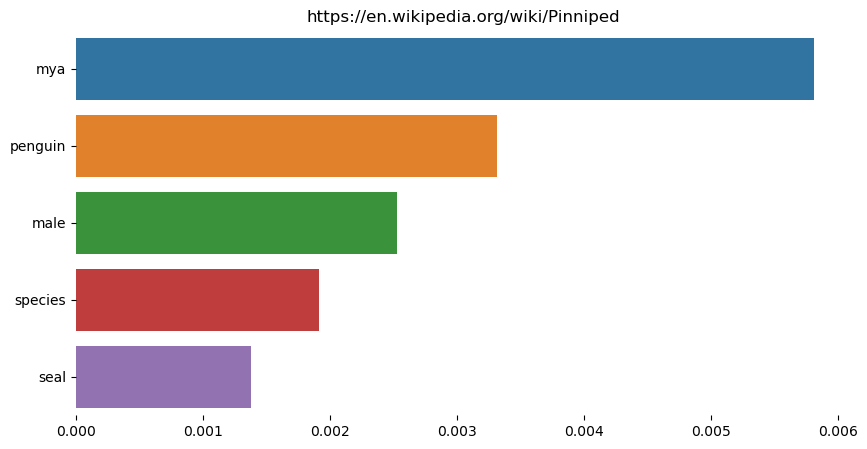

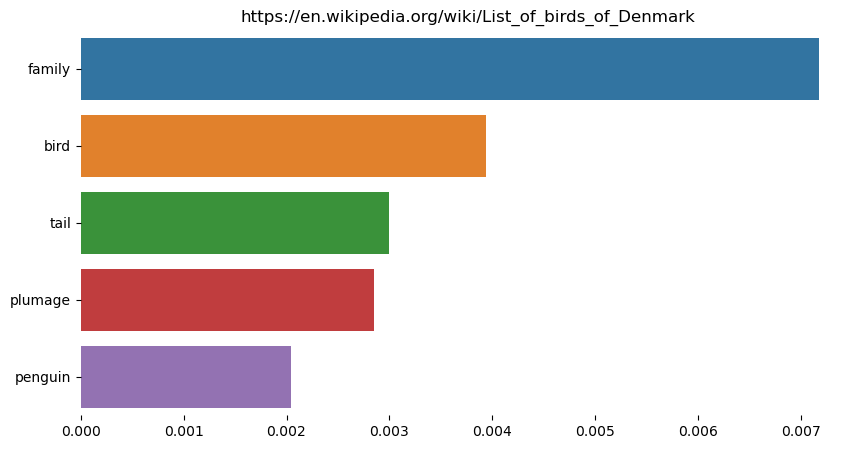

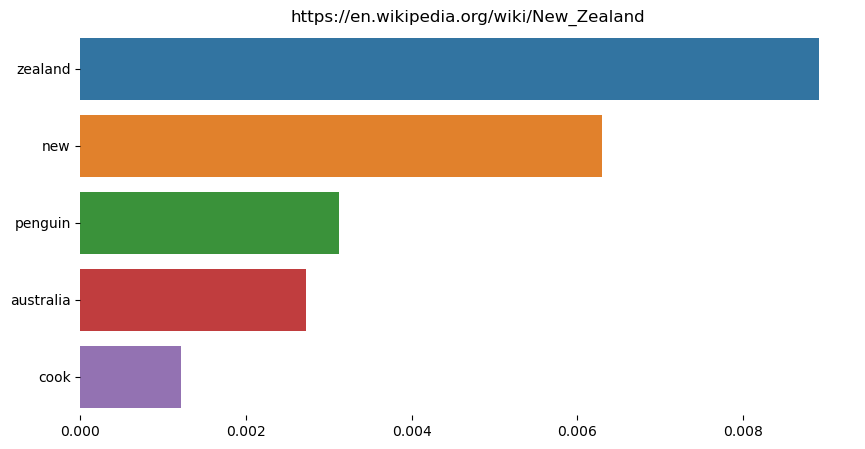

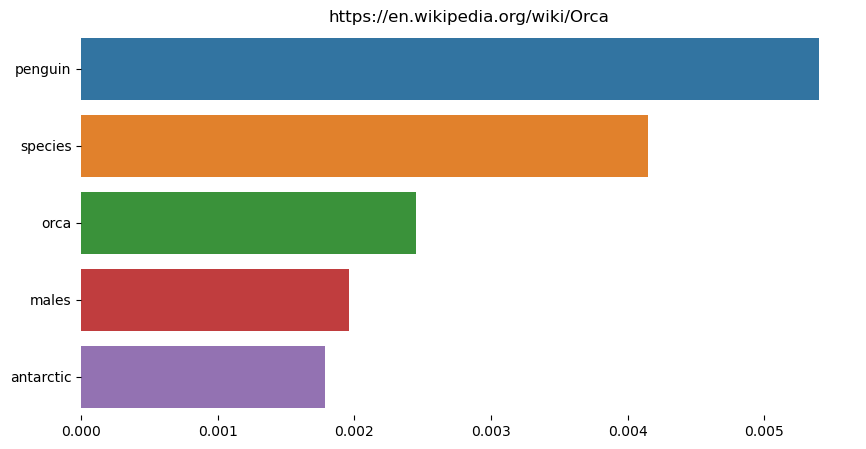

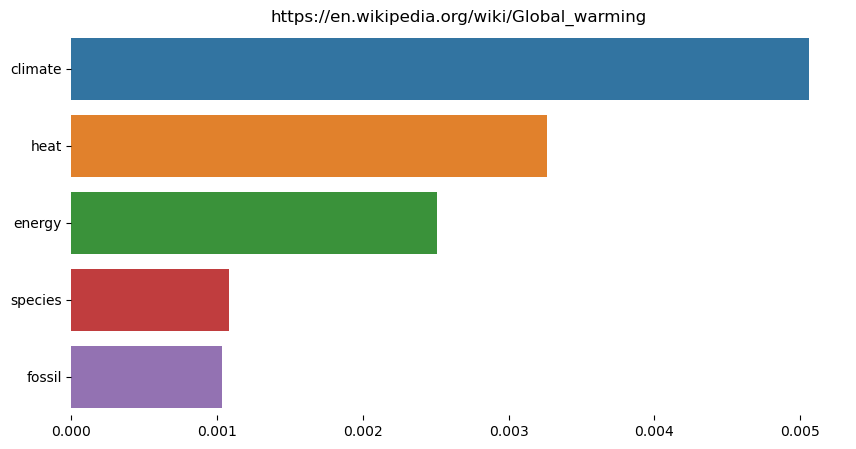

In [11]:
urls = ["https://en.wikipedia.org/wiki/Kangaroo", "https://en.wikipedia.org/wiki/Penguin"]
queries = [search.wiki_page_from_url_to_content_text(url) for url in urls]

scores_df = engine.get_scores_dataframe_from_queries(queries, top_n=6)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 5)

Surprisingly, it turns out that even for words from the other side of the globe, we find the perfect article, i.e. Australia and New Zealand. The only places on Earth where both animals occur in the wild. We also get other animals from those regions of the world and a list of birds from Denmark and an article about global warming. Analyzing the individual words that had the most important meaning, it can be seen that most of them come from the article about penguins, this is probably due to the fact that the word penguin appeared in our database and the word kangaroo did not, but nevertheless the most important words from both articles, i.e. "australia" and "zealand".

## Random articles

We can also check how our program for random articles works.

### Preparing engine and analysing data

In [18]:
random_docs_df = pd.read_parquet("unrelated_large_set.pq")
random_texts = random_docs_df.text.tolist()
random_texts = [text.replace(";", " ") for text in random_texts]

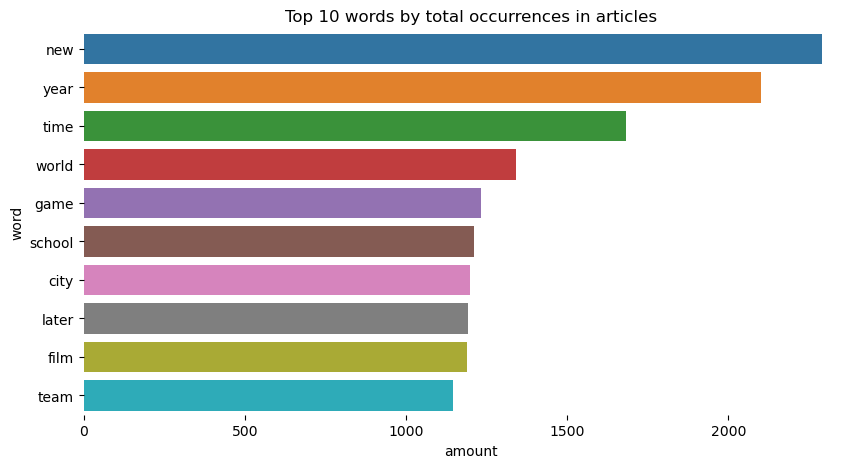

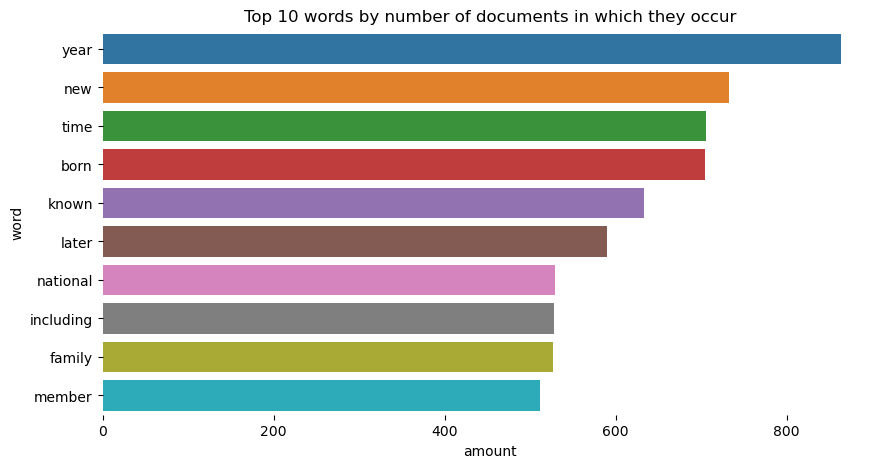

In [19]:
random_visualize_df = random_docs_df.copy(deep = True)
random_visualize_df.text = random_texts
visualize.visualize_most_frequent(random_visualize_df, 10)
visualize.visualize_most_frequent(random_visualize_df, 10, method="count")

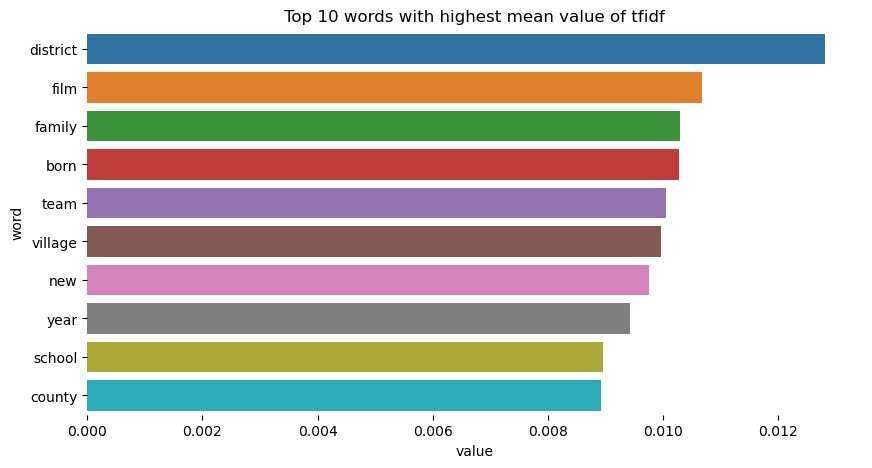

In [20]:
random_engine = search.SimpleSearchEngine()
random_engine.compile_index(random_texts, random_docs_df.url.tolist())
visualize.visualize_tfidf(random_engine.index, 10)

In the case of random articles, it can be seen that there are few very specific words. These are very common words, right after the words excluded in stop words.

### Similarities

Let's start with the same articles as in previous case for example Berlin and Moscow

https://en.wikipedia.org/wiki/Novoivanovskoye                           0.168945
https://en.wikipedia.org/wiki/Metropolitan_regions_in_Germany           0.162176
https://en.wikipedia.org/wiki/3rd_Moscow_International_Film_Festival    0.125210
Name: _SCORE_TOTAL, dtype: float64


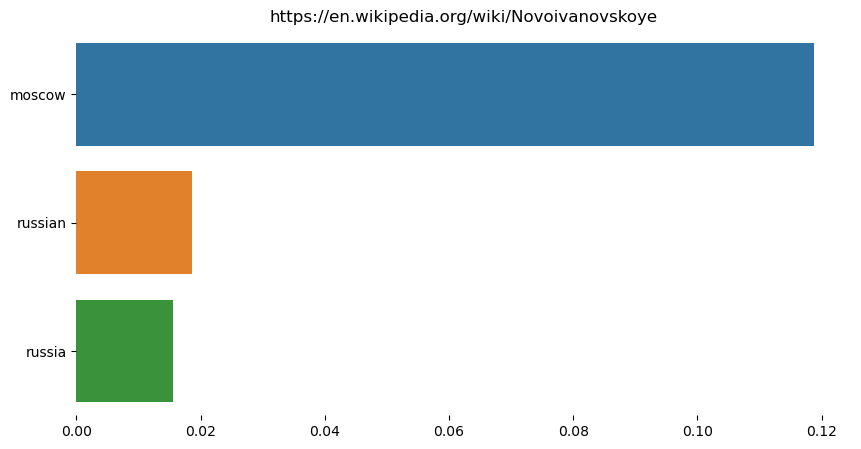

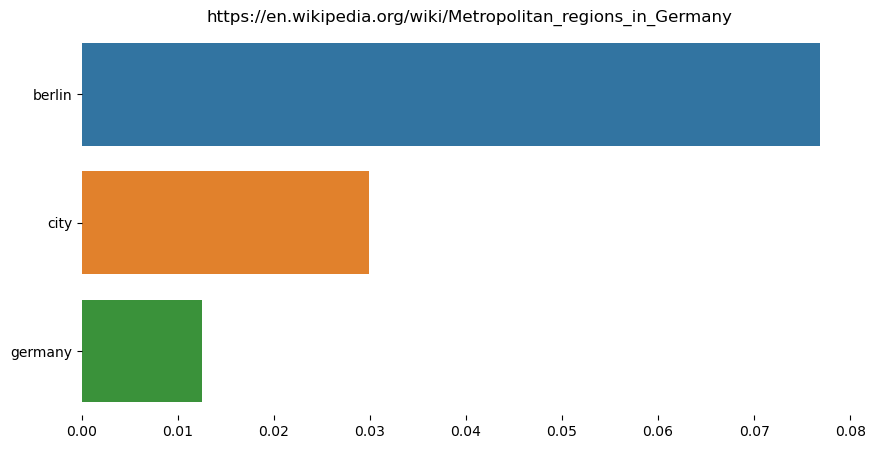

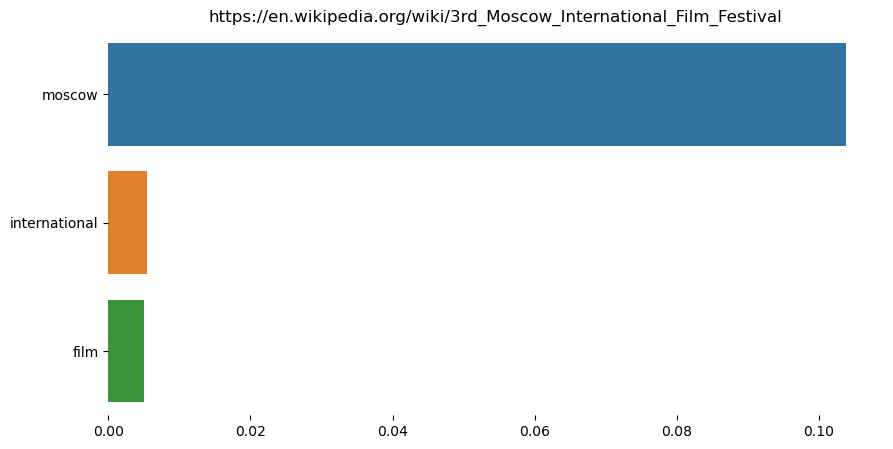

In [21]:
urls = ["https://en.wikipedia.org/wiki/Berlin", "https://en.wikipedia.org/wiki/Moscow"]
queries = [search.wiki_page_from_url_to_content_text(url) for url in urls]

scores_df = random_engine.get_scores_dataframe_from_queries(queries, top_n=3)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 3)

It can be seen that the articles are much less closer to the topics than the previous time, there are few words by which to combine the articles.

https://en.wikipedia.org/wiki/Gentoo_penguin                   0.261477
https://en.wikipedia.org/wiki/Partula_taeniata                 0.127107
https://en.wikipedia.org/wiki/List_of_birds_of_Saint_Martin    0.115729
Name: _SCORE_TOTAL, dtype: float64


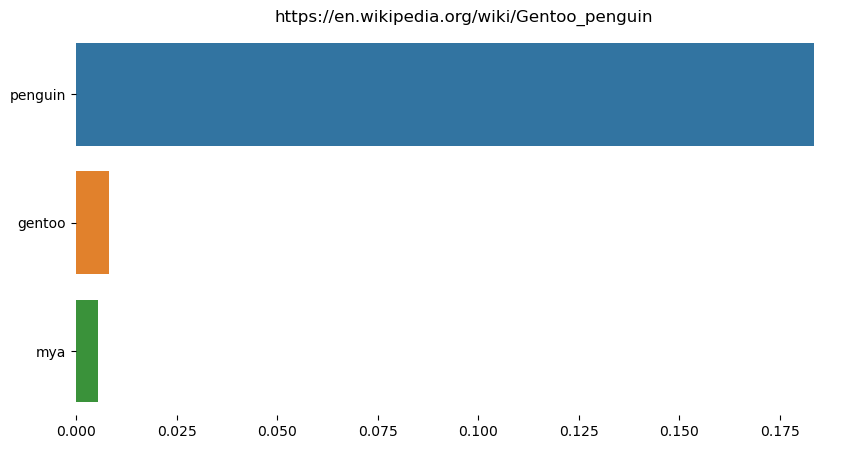

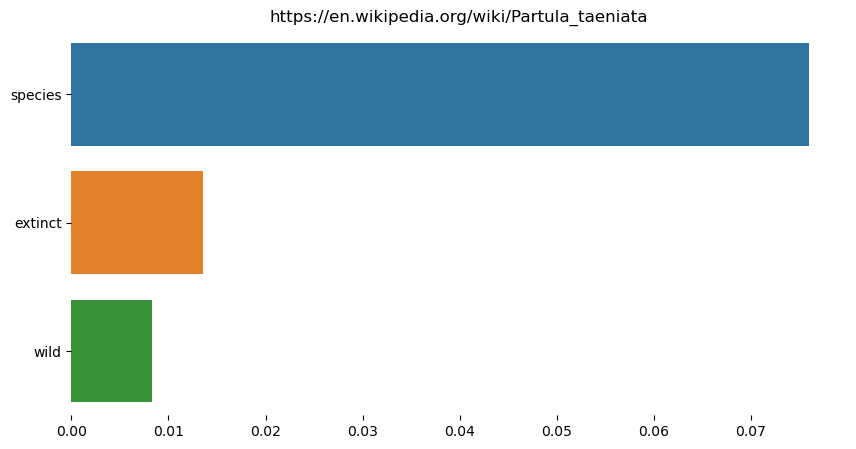

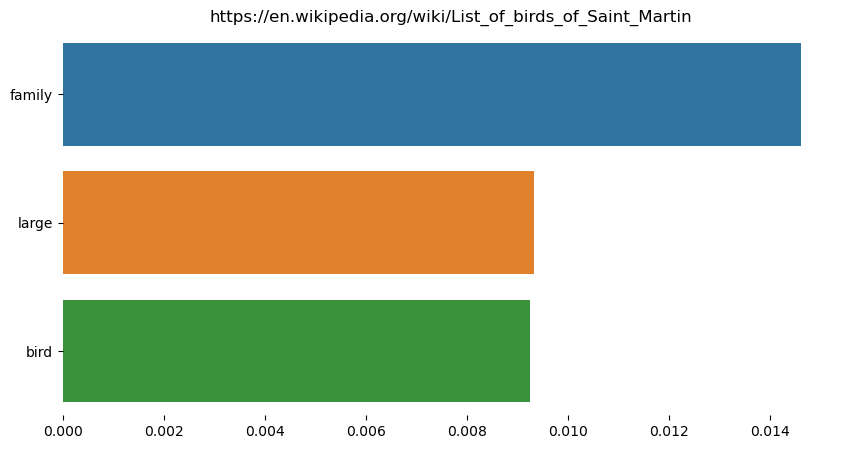

In [22]:
urls = ["https://en.wikipedia.org/wiki/Kangaroo", "https://en.wikipedia.org/wiki/Penguin"]
queries = [search.wiki_page_from_url_to_content_text(url) for url in urls]

scores_df = random_engine.get_scores_dataframe_from_queries(queries, top_n=3)
print(scores_df.iloc[:, -1])
visualize.visualize_top_scores(scores_df, 3)

Once again, the results obtained are less related to the given links.

### Conclusion
Random articles are worse in the sense of finding similar articles. This is due to a number of things:
-   Random articles are often very short
-   All pages are not very related to each other
-   A lot of words are not repeated
-   Articles are often very specific, often dedicated to different people